In [2]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import competitors as competitors
import synthetic_signal as synth
import matplotlib.pyplot as plt
import numpy as np
from utils import transfrom_label
import plotting as plotting

In [21]:
class LoCoMotif(object):
    
    def __init__(self,n_motifs=1, lmin=50,lmax=200,rho=0.8,delta_m=0.5,overlap=0.5) -> None:

        self.n_motifs=n_motifs 
        self.lmin = lmin 
        self.lmax =lmax
        self.rho = rho
        self.delta_m=delta_m
        self.overlap=overlap

    def compute_SSM(self):
        self.SSM_ = np.exp(-squareform(pdist(self.signal_))**2)
        self.tau=np.quantile(self.SSM_,self.rho)
        self.delta_a=2*self.tau

    def position_dependant_function(self,i,j,sigma):
        if self.SSM_[i,j]>= self.tau:
            return sigma + self.SSM_[i,j]
        else:
            return max(0,self.delta_m *sigma-self.delta_a)
        
    def compute_D(self):

        self.D=np.zeros((self.n,self.n))

        for j in range(self.n):
            self.D[0,j] = self.position_dependant_function(0,j,0)
            self.D[j,0] = self.position_dependant_function(j,0,0)

        for i in range(1,self.n):
            for j in range(1,self.n):
                admissible_origins=[[i-1,j-1],[i-1,j-2],[i-2,j-1]]
                distances=[]
                for k,l in admissible_origins:
                    if k>=0 and l>=0:
                        distances.append(self.D[k,l])
                self.D[i,j]= self.position_dependant_function(i,j,max(distances))
                

    def backtrack(self,i,j,mask):
        #peut être plus élégant
        p=[]
        curr_i,curr_j=i,j
        while mask[curr_i,curr_j] == 0:
            p = [[curr_i,curr_j]] + p
            admissible_origins=[[curr_i-1,curr_j-1],[curr_i-1,curr_j-2],[curr_i-2,curr_j-1]]
            distances=[]
            idxs=[]
            for k,l in admissible_origins:
                if k>=0 and l>=0:
                    distances.append(self.D[curr_i,curr_j])
                    idxs.append([k,l])
            if len(distances)==0:
                #in this case we have reached a border of D
                break
            else:
                curr_i,curr_j=idxs[np.argmin(distances)]
        return np.array(p)
            
    def LoCo(self):

        self.paths=[]
        mask=np.zeros((self.n,self.n))
        mask[np.where(self.D==0)]=1

        while not mask.all():
            masked_D=np.ma.masked_array(self.D,mask)
            i,j=np.unravel_index(np.ma.argmax(masked_D),masked_D.shape)

            p = self.backtrack(i,j,mask)

            if p[-1,0]-p[0,0]>=self.lmin and p[-1,1]-p[0,1] >= self.lmin:

                self.paths.append(p)
                #mask the vicinity of p
                for k,l in p:
                    sub_horizontal_mask=np.arange(max(0,k-self.lmin//2),min(k+1+self.lmin//2,self.n))
                    sub_vertical_mask=np.arange(max(0,l-self.lmin//2),min(l+1+self.lmin//2,self.n))

                    mask[sub_horizontal_mask,l]=1
                    mask[k,sub_vertical_mask]=1
            else:
                for k,l in p:
                    mask[k,l]=1

        return self.paths 

    def fitness(self,P_alpha,M_alpha):

        score=0
        sum_paths_len=0
        coverage=0

        alpha_len= P_alpha[0][-1,1]-P_alpha[0][0,1]

        for q in P_alpha:

            sum_paths_len+=q.shape[0]

            pi1=np.arange(q[0,0],q[-1,0]+1)
            coverage+=pi1.shape[0]

            for i,j in q:
                score+=self.SSM_[i,j]
        
        for beta_1 in M_alpha:
            for beta_2 in M_alpha:
                if not (beta_1==beta_2).all():
                    coverage-=np.intersect1d(beta_1,beta_2).shape[0]
        
        score= (score - alpha_len)/sum_paths_len
        coverage= (coverage- alpha_len)/self.n

        return 2*score*coverage/(score+coverage)
        

    def get_candidate_motif(self,P_e,alpha):
        
        P_alpha=[]
        M_alpha=[]

        for p in P_e:
            #the condition given in the paper is not sufficient, for ex we can have a jump from e-1 to e+1, so we also check if b and e are in p
            if not ((p[:,1]==alpha[0]).any() and (p[:,1]==alpha[-1]).any()):
                continue
            begin_index=np.where(p[:,1]==alpha[0])[0][0]
            end_index=np.where(p[:,1]==alpha[-1])[-1][0]
            q=p[begin_index:end_index]
            beta = np.arange(q[0,0],q[-1,0]+1)
                    
            #check if the segment coincides with an already found segment 
            beta_coincide=False
            for motif_set in self.motifs:
                if beta_coincide:
                    break
                for beta_2 in motif_set:
                    if np.intersect1d(beta,beta_2).shape[0]> self.overlap * beta_2.shape[0]:
                        beta_coincide=True
                        break
            if not beta_coincide:
                P_alpha.append(q)
                M_alpha.append(beta)

            #check if there is inter set coincidence
        inter_set_coincidence=False
        for beta_1 in M_alpha:
            if inter_set_coincidence:
                break
            for beta_2 in M_alpha:
                if not (beta_1==beta_2).all():
                    if np.intersect1d(beta_1,beta_2).shape[0]> self.overlap * beta_2.shape[0]:
                        inter_set_coincidence=True
                        break   
        return P_alpha,M_alpha,inter_set_coincidence

    def bestMotifSet(self):
        M_alpha_star = []
        phi_alpha_star = 0
        P_b=[]
        for b in range(self.n-self.lmin):
            #we remove paths which ends in b-1
            P_b=[p for p in P_b if p[-1,1]!=b-1]
            #we add paths which begins in b
            for p in self.paths:
                if p[0,1]==b:
                    P_b.append(p)
            if len(P_b)==0:
                continue
            P_e = P_b
            for e in range(b+self.lmin,min(b+self.lmax+1,self.n)):
                P_e=[p for p in P_e if p[-1,1]!=e-1]
                if len(P_e)==0:
                    continue
                alpha=np.arange(b,e+1)
                
                
                #check if alpha coincides with an already found segment
                alpha_coincide=False
                for motif_set in self.motifs:
                    if alpha_coincide:
                        break
                    for beta in motif_set:
                        if np.intersect1d(alpha,beta).shape[0]> self.overlap * beta.shape[0]:
                            alpha_coincide=True
                            break
                if alpha_coincide:
                    break

                P_alpha,M_alpha,inter_set_coincidence= self.get_candidate_motif(P_e,alpha)
                if inter_set_coincidence:
                    continue 

                phi_alpha=self.fitness(P_alpha,M_alpha)
                if phi_alpha > phi_alpha_star:
                    M_alpha_star=M_alpha
                    phi_alpha_star=phi_alpha

        return M_alpha_star


        
    def fit(self,signal):

        if len(signal.shape)==1:
            signal=signal.reshape(-1,1)
        self.signal_ = signal
        self.n, self.d = self.signal_.shape

        self.compute_SSM()
        self.compute_D()
        
        self.LoCo()
        self.motifs=[]
        while len(self.motifs) < self.n_motifs:
            M_alpha= self.bestMotifSet()
            if len(M_alpha)==0:
                break
            self.motifs.append(M_alpha)
        
        return self.motifs
    
    @property
    def prediction_mask_(self):
        mask=np.zeros((self.n_motifs,self.signal_.shape[0]))
        for i in range(len(self.motifs)):
            motif=self.motifs[i]
            for sub_motif in motif:
                mask[i,sub_motif]=1
        return mask





In [3]:
signal_generator = synth.SignalGenerator(2,motif_length=50,walk_amplitude=0.1,motif_fundamental=6,sparsity=2,sparsity_fluctuation=0.5)
signal,labels= signal_generator.generate()
signal_generator.plot()

In [25]:
loc=LoCoMotif(2,overlap=0,lmin=40,lmax=60)
loc.fit(signal)

[[array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
         57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
         74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
         91, 92, 93, 94, 95, 96, 97, 98]),
  array([220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
         233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
         246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
         259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
         272, 273, 274, 275, 276, 277, 278])],
 [array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
         113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
         139, 140, 141, 142]),
  array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
         173, 174, 175, 176, 177, 178, 179, 180, 181, 18

(<Figure size 1000x400 with 1 Axes>, <Axes: >)

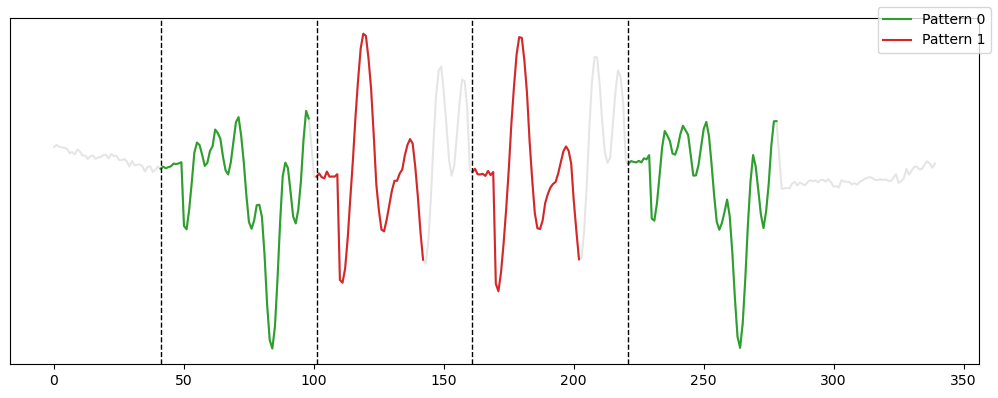

In [30]:
labels=transfrom_label(loc.prediction_mask_)
plotting.plot_signal_pattern(signal,labels)